# Replicate: MobileSAM 
### .onnx cpu only
July 28th

In [ ]:
# New conda env

"""
# clean env wipe & activate
conda env remove --name mobilesam_py310 -y
conda create -n MobileSAM_onnx python=3.10 -y
conda activate MobileSAM_onnx

sudo apt update
sudo apt install libcudnn8 libcudnn8-dev
conda install -c conda-forge libstdcxx-ng=12 -y

# Instalation of MobileSAM repo requirements

pip install git+https://github.com/ChaoningZhang/MobileSAM.git

# pip install -r requirements.txt
# python setup.py install
pip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3 'opencv-python<4.9'


# typical np version mismatch
pip uninstall -y numpy
pip install "numpy>=1.19.2,<2.0"
# pip install numpy==1.26.4 

# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)
pip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl

# download torchvision 0.20.0a0 (compatible with jp61 torch)
cd ~/vision/
python3 setup.py install
cd ~

# Install ONNX runtime (REPO INSTRUCTIONS: We recommend to use onnx==1.12.0 onnxruntime==1.13.1 which is tested)
pip install onnx==1.12.0 onnxruntime==1.13.1

"""

# Debug Support

# Check your conda env GLIBCXX versions
# strings /home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6 | grep GLIBCXX

# trt2torch is apparently an issue and is obsolete for trt --version=10.3.0 
# additionally `pip install pycuda`

'\n# clean env wipe & activate\nconda env remove --name mobilesam_py310 -y\nconda create -n MobileSAM_onnx python=3.10 -y\nconda activate MobileSAM_onnx\n\nsudo apt update\nsudo apt install libcudnn8 libcudnn8-dev\nconda install -c conda-forge libstdcxx-ng=12 -y\n\n# Instalation of MobileSAM repo requirements\n\npip install git+https://github.com/ChaoningZhang/MobileSAM.git\n\n# pip install -r requirements.txt\n# python setup.py install\npip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3 \'opencv-python<4.9\'\n\n\n# typical np version mismatch\npip uninstall -y numpy\npip install "numpy>=1.19.2,<2.0"\n# pip install numpy==1.26.4 \n\n# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)\npip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl\n\n# download torchvision 0.20.0a0 (compatible with jp61 torch)\ncd ~/vision/\npython3 setup.py install\ncd ~\n\n#

In [2]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from mobile_sam import sam_model_registry, SamPredictor
from mobile_sam.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

/home/copter/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/copter/.local/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-pac

In [ ]:
# ONNX FastSAM Inference Setup - Fix cuDNN version issue
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import torch
from PIL import Image
import os
import sys
from typing import List, Tuple, Any
import time

# Add FastSAM utils if needed for compatibility
sys.path.append('/home/copter/MobileSAM')

# Update library path to ensure cuDNN is found
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/aarch64-linux-gnu:' + os.environ.get('LD_LIBRARY_PATH', '')

print(f"ONNX Runtime version: {ort.__version__}")
available_providers = ort.get_available_providers()
print(f"Available ORT providers: {available_providers}")

ONNX Runtime version: 1.13.1
Available providers: ['CPUExecutionProvider']
Provider chain: ['CPUExecutionProvider']


In [4]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

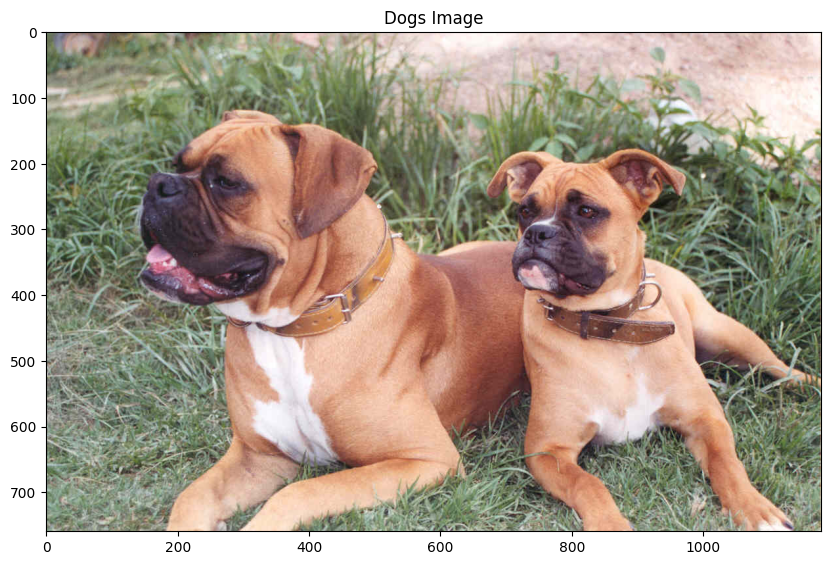

Image size: 2690400


In [5]:
# Load and display image
image_path = "/home/copter/jetson_benchmark/images/dogs.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('on')
plt.title("Dogs Image")
plt.show()

print(f"Image size: {image.size}")

In [6]:
# ONNX & PT model configuration

checkpoint = "/home/copter/weights/chaoningzhang_mobile_sam.pt" # Adjust this path
model_type = "vit_t" # Or "vit_h", "vit_l" if using full SAM

# Instantiate the PyTorch SAM model
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device='cpu') # Or 'cuda' if you have a GPU

model_path = "/home/copter/onnx_models/chaoningzhang_mobile_sam.onnx"
ort_session = onnxruntime.InferenceSession(model_path)

sam.to(device='cpu')
predictor = SamPredictor(sam)


predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
image_embedding.shape


/home/copter/miniconda3/envs/MobileSAM_onnx/lib/python3.10/site-packages/mobile_sam/build_sam.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

(1, 256, 64, 64)

### Example point input

In [11]:
# ...
input_point = np.array([[430, 400]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)


In [12]:
# ...

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}



Shape of mask passed to show_mask: (760, 1180)


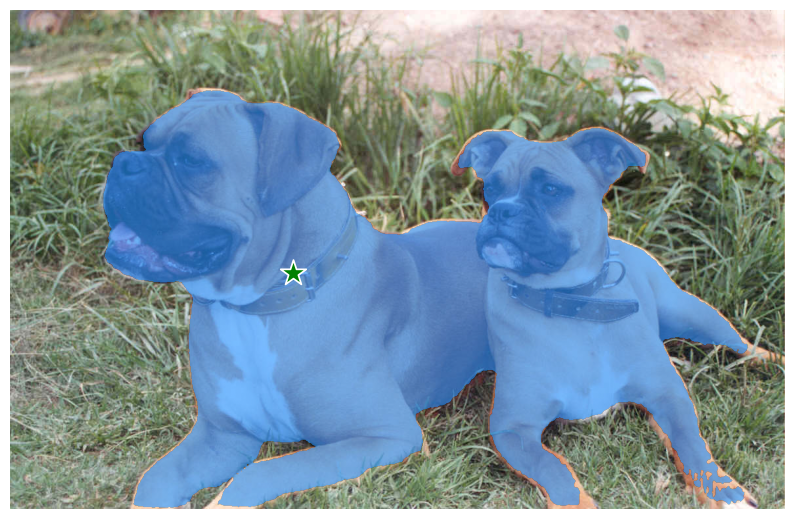

In [16]:
# Predict a mask and threshold it
masks, iou_predictions, low_res_logits = ort_session.run(None, ort_inputs)

# 'masks' now has shape (1, 4, H, W) where H=760, W=1180
# 'iou_predictions' will have shape (1, 4)

# Threshold the masks first
thresholded_masks = masks > predictor.model.mask_threshold

# Now, select one of the four masks to display with show_mask.
# You have a few options:

# Option 1: Display the first mask (simplest)
# selected_mask_to_show = thresholded_masks[0, 0, :, :] # This selects the first mask from the batch, and the first of the 4 masks

# Option 2: Display the mask with the highest predicted IoU (more robust)
# Assuming iou_predictions also has a shape like (1, 4)
best_mask_idx = np.argmax(iou_predictions[0]) # Find the index of the highest IoU score in the batch (0)
selected_mask_to_show = thresholded_masks[0, best_mask_idx, :, :]

print("Shape of mask passed to show_mask:", selected_mask_to_show.shape) # Should now be (760, 1180)

plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(selected_mask_to_show, plt.gca()) # Pass the explicitly selected 2D mask
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


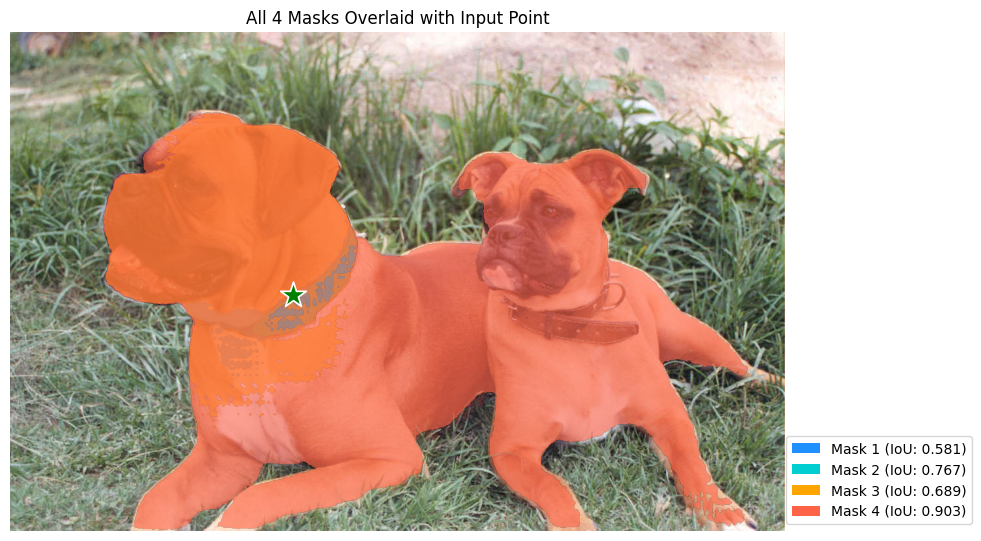

In [17]:
# Assuming 'image', 'thresholded_masks', 'iou_predictions', 'input_point', 'input_label'
# are still available from the previous cell's execution.

plt.figure(figsize=(10,10))
plt.imshow(image) # Display the original image once

# Create a list to hold legend handles and labels
legend_handles = []
legend_labels = []

# Iterate through all 4 masks
for i in range(thresholded_masks.shape[1]): # Looping from 0 to 3
    current_mask = thresholded_masks[0, i, :, :] # Select the i-th mask
    current_iou = iou_predictions[0, i] # Get its corresponding IoU score

    # Define a unique color for each mask for better distinction
    # You can customize these colors. RGB with alpha
    colors = [
        np.array([30/255, 144/255, 255/255, 0.6]), # Dodger Blue
        np.array([0/255, 206/255, 209/255, 0.6]),  # Dark Cyan
        np.array([255/255, 165/255, 0/255, 0.6]),  # Orange
        np.array([255/255, 99/255, 71/255, 0.6])   # Tomato
    ]
    mask_color = colors[i % len(colors)] # Cycle through colors if more than 4 masks later

    # Overlay the current mask using the customized color
    h, w = current_mask.shape[-2:]
    mask_image = current_mask.reshape(h, w, 1) * mask_color.reshape(1, 1, -1)
    plt.gca().imshow(mask_image)

    # Add to legend data
    legend_handles.append(plt.Rectangle((0,0),1,1, fc=mask_color[:3])) # Use only RGB for legend patch
    legend_labels.append(f"Mask {i+1} (IoU: {current_iou:.3f})")

show_points(input_point, input_label, plt.gca()) # Show the input point(s)

plt.axis('off')
plt.title("All 4 Masks Overlaid with Input Point")
plt.legend(legend_handles, legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0)) # Adjust loc as needed
plt.show()